# **Import the Libraries**

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import the Libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Install umap
!pip install umap-learn
import umap

# **Load data**

In [ ]:
# Read data from CSV file
data = pd.read_csv("/content/drive/MyDrive/Data Science/Fifa_world_cup_matches.csv")
data.tail()

team1    team2 possession team1 possession team2  \
59    ENGLAND   FRANCE              54%              36%   
60  ARGENTINA  CROATIA              34%              54%   
61     FRANCE  MOROCCO              34%              55%   
62    CROATIA  MOROCCO              45%              45%   
63  ARGENTINA   FRANCE              46%              40%   

   possession in contest  number of goals team1  number of goals team2  \
59                   10%                      1                      2   
60                   12%                      3                      0   
61                   11%                      2                      0   
62                   10%                      2                      1   
63                   14%                      3                      3   

           date     hour                  category  total attempts team1  \
59  10 DEC 2022  20 : 00             Quarter-final                    14   
60  13 DEC 2022  20 : 00                Semi-final                    10   
61  14 DEC 2022  20 : 00                Semi-final                    14   
62  17 DEC 2022  16 : 00  Play-off for third place                    14   
63  18 DEC 2022  16 : 00                     Final                    21   

    total attempts team2  conceded team1  conceded team2  \
59                     9               2               1   
60                    12               0               3   
61                    13               0               2   
62                     7               1               2   
63                    10               3               3   

    goal inside the penalty area team1  goal inside the penalty area team2  \
59                                   1                                   1   
60                                   3                                   0   
61                                   2                                   0   
62                                   2                                   1   
63                                   3                                   3   

    goal outside the penalty area team1  goal outside the penalty area team2  \
59                                    0                                    1   
60                                    0                                    0   
61                                    0                                    0   
62                                    0                                    0   
63                                    0                                    0   

    assists team1  assists team2  on target attempts team1  \
59              0              2                         6   
60              1              0                         7   
61              0              0                         2   
62              2              0                         4   
63              1              1                         9   

    on target attempts team2  off target attempts team1  \
59                         5                          4   
60                         3                          2   
61                         1                          8   
62                         2                          8   
63                         5                          9   

    off target attempts team2  attempts inside the penalty area team1  \
59                          3                                       6   
60                          7                                       7   
61                          6                                      12   
62                          5                                       7   
63                          3                                      10   

    attempts inside the penalty area  team2  \
59                                        6   
60                                        6   
61                                        8   
62                                        5   
63                              

# **Data Cleaning**

In [ ]:
# Print data informations
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 88 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   team1                                                  64 non-null     object
 1   team2                                                  64 non-null     object
 2   possession team1                                       64 non-null     object
 3   possession team2                                       64 non-null     object
 4   possession in contest                                  64 non-null     object
 5   number of goals team1                                  64 non-null     int64 
 6   number of goals team2                                  64 non-null     int64 
 7   date                                                   64 non-null     object
 8   hour                                                   64 non-



*   Columns to Drop: [date, hour, category]
*   Column to Convert: [possession team]
*   Correcting Whitespace Issues in Column Names



In [ ]:
# Drop unnecessary columns
data = data.drop(labels=['date', 'hour', 'category'], axis=1)
data.head()

# Convert 'possession' columns from object type to integer type
def deletePercent(x):
    return int(x.replace('%', ''))

data['possession team1'] = data['possession team1'].apply(deletePercent)
data['possession team2'] = data['possession team2'].apply(deletePercent)
data['possession in contest'] = data['possession in contest'].apply(deletePercent)

# Rename columns for better readability
# team1_data.columns = team1_data.columns.map(lambda x: x.replace('team1', 'team'))
data = data.rename(columns={'completed line breaksteam1': 'completed line breaks team1',
                            'completed defensive line breaksteam1': 'completed defensive line breaks team1',
                            'attempts inside the penalty area  team2' : 'attempts inside the penalty area team2'})

*   Restructure the data to the desired format.

In [ ]:
def getTeamInformation(data, team_name):

    # Filter data for matches involving the team
    team1_data = data[data['team1'] == team_name]
    team2_data = data[data['team2'] == team_name]

    # Select relevant columns for each team data
    team1_related_cols = [col for col in team1_data.columns if 'team1' in col]
    team2_related_cols = [col for col in team2_data.columns if 'team2' in col]
    team1_data = team1_data[team1_related_cols]
    team2_data = team2_data[team2_related_cols]

    # Combine team data with appropriate column renaming
    team1_data.columns = team1_data.columns.str.replace('team1', 'Average')
    team2_data.columns = team2_data.columns.str.replace('team2', 'Average')
    team_data = pd.concat([team1_data, team2_data])

    # Reset index and remove unnecessary column
    team_data = team_data.reset_index()
    team_data = team_data.drop(labels='index', axis=1)

    # Rename 'Average ' prefix to 'name' and calculate average statistics
    team_data = team_data.rename(columns={'Average': 'name'})
    team_data = team_data.drop(labels='name', axis=1)
    team_data = team_data.mean()
    team_data = pd.DataFrame(team_data).transpose()     # Reshape to DataFrame

    # Rename index to the team name
    team_data = team_data.rename(index={0: team_name})

    return team_data

# Initialize empty DataFrame to store results
data_transformed = pd.DataFrame()

# Get list of team names
team_list = list(set(data['team1'].values))

# Get information for each team and concatenate DataFrames
for name in team_list:
    team_df = getTeamInformation(data, name)
    data_transformed = pd.concat([data_transformed, team_df])

# Sort result by team name
data_transformed = data_transformed.sort_index()

# Drop unnecessary columns
data_transformed = data_transformed.drop(labels=['red cards Average', 'yellow cards Average', 'own goals Average'], axis=1)

data_transformed

possession Average  number of goals Average  \
ARGENTINA                51.142857                 2.142857   
AUSTRALIA                31.250000                 1.000000   
BELGIUM                  49.666667                 0.333333   
BRAZIL                   50.400000                 1.600000   
CAMEROON                 38.333333                 1.333333   
CANADA                   47.000000                 0.666667   
COSTA RICA               27.666667                 1.000000   
CROATIA                  48.000000                 1.142857   
DENMARK                  53.000000                 0.333333   
ECUADOR                  46.666667                 1.333333   
ENGLAND                  57.800000                 2.600000   
FRANCE                   44.857143                 2.285714   
GERMANY                  52.666667                 2.000000   
GHANA                    37.666667                 1.666667   
IRAN                     31.333333                 1.333333   
JAPAN                    29.750000                 1.250000   
KOREA REPUBLIC           42.250000                 1.250000   
MEXICO                   48.333333                 0.666667   
MOROCCO                  34.857143                 0.857143   
NETHERLANDS              45.000000                 2.000000   
POLAND                   31.750000                 0.750000   
PORTUGAL                 54.200000                 2.400000   
QATAR                    40.666667                 0.333333   
SAUDI ARABIA             36.666667                 1.000000   
SENEGAL                  39.750000                 1.250000   
SERBIA                   42.666667                 1.666667   
SPAIN                    69.000000                 2.250000   
SWITZERLAND              43.000000                 1.250000   
TUNISIA                  37.666667                 0.333333   
UNITED STATES            47.500000                 0.750000   
URUGUAY                  41.000000                 0.666667   
WALES                    41.000000                 0.333333   

                total attempts Average  conceded Average  \
ARGENTINA                    14.857143          1.142857   
AUSTRALIA                     6.250000          1.500000   
BELGIUM                      11.333333          0.666667   
BRAZIL                       18.000000          0.600000   
CAMEROON                      9.000000          1.333333   
CANADA                       11.666667          2.333333   
COSTA RICA                    4.000000          3.666667   
CROATIA                      11.571429          1.000000   
DENMARK                      11.666667          1.000000   
ECUADOR                       9.000000          1.000000   
ENGLAND                      12.000000          0.800000   
FRANCE                       14.428571          1.142857   
GERMANY                      22.333333          1.666667   
GHANA                         8.333333          2.333333   
IRAN                         11.666667          2.333333   
JAPAN                        10.500000          1.000000   
KOREA REPUBLIC               12.250000          2.000000   
MEXICO                       14.000000          1.000000   
MOROCCO                       8.714286          0.714286   
NETHERLANDS                   8.000000          0.800000   
POLAND                        7.750000          1.250000   
PORTUGAL                     12.400000          1.200000   
QATAR                         7.000000          2.333333   
SAUDI ARABIA                  9.666667          1.666667   
SENEGAL                      12.750000          1.750000   
SERBIA                       10.333333          2.666667   
SPAIN                        12.750000          0.750000   
SWITZERLAND                   9.000000          2.250000   
TUNISIA                       9.666667          0.333333   
UNITED STATES                11.500000          1.000000   
URUGUAY                      10.666667          0.666667   
WALES           

In [ ]:
data_transformed.describe()

possession Average  number of goals Average  total attempts Average  \
count           32.000000                32.000000               32.000000   
mean            43.515848                 1.243080               10.970461   
std              8.985081                 0.664890                3.457294   
min             27.666667                 0.333333                4.000000   
25%             37.666667                 0.729167                8.928571   
50%             42.833333                 1.250000               11.000000   
75%             48.666667                 1.666667               12.287500   
max             69.000000                 2.600000               22.333333   

       conceded Average  goal inside the penalty area Average  \
count         32.000000                             32.000000   
mean           1.434375                              1.130952   
std            0.752015                              0.664043   
min            0.333333                              0.000000   
25%            0.950000                              0.702381   
50%            1.171429                              1.000000   
75%            2.000000                              1.616667   
max            3.666667                              2.400000   

       goal outside the penalty area Average  assists Average  \
count                              32.000000        32.000000   
mean                                0.093899         0.875149   
std                                 0.125587         0.549268   
min                                 0.000000         0.000000   
25%                                 0.000000         0.333333   
50%                                 0.000000         0.750000   
75%                                 0.200000         1.333333   
max                                 0.333333         2.200000   

       on target attempts Average  off target attempts Average  \
count                   32.000000                    32.000000   
mean                     3.817783                     4.838839   
std                      1.595922                     1.774242   
min                      1.750000                     0.666667   
25%                      2.729167                     3.937500   
50%                      3.416667                     4.750000   
75%                      4.541667                     5.666667   
max                      8.200000                    11.000000   

       attempts inside the penalty area Average  \
count                                 32.000000   
mean                                   6.761830   
std                                    2.535967   
min                                    2.333333   
25%                                    5.666667   
50%                                    6.666667   
75%                                    7.666667   
max                                   15.333333   

       attempts outside the penalty area  Average  left channel Average  \
count                                   32.000000             32.000000   
mean                                     4.208631             13.256920   
std                                      1.335895              4.454836   
min                                      1.500000              6.666667   
25%                                      3.533333             10.187500   
50%                                      4.000000             12.375000   
75%                                      4.892857             15.785714   
max                                      7.000000             27.000000   

       left inside channel Average  central channel Average  \
count                    32.000000                32.000000   
mean                      4.577976                 4.865848   
std                       1.856362                 1.858321   
min                       1.571429                 1.666667   
25%                       3.625000                 3.857143   
50%                    

In [ ]:
# Calculate the correlation matrix for the transformed data
correlation_matrix= data_transformed.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Heatmap of Feature Correlations')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **Data Preprocessing**

In [ ]:
# Create a copy of the transformed data DataFrame to avoid modifying the original
data_transformed_copy = data_transformed.copy()

# Initialize a StandardScaler object to standardize the data
standard_scaler = StandardScaler()
data_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(data_transformed_copy),
                                  index = data_transformed_copy.index,
                                  columns = data_transformed_copy.columns)

# **Dimension Reducion**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-149-a958c3225307>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)


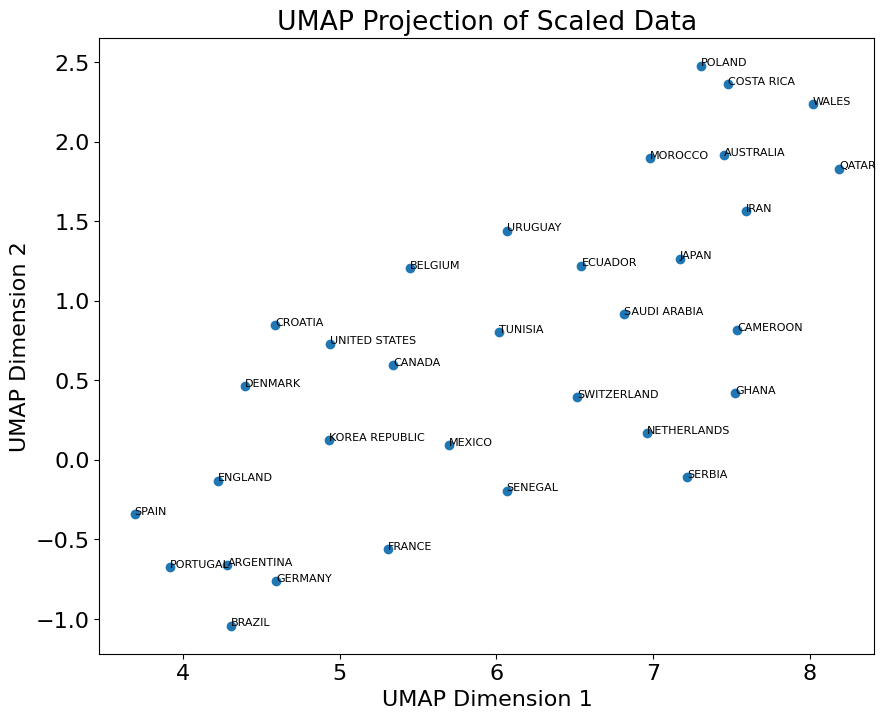

In [ ]:
# Create a UMAP model and apply it to the data
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=0)
embedding = reducer.fit_transform(data_standard_scaled)

# Create a DataFrame for the embedding with country names
data_umap = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=data_standard_scaled.index)

# Visualize the UMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(data_umap['UMAP1'], data_umap['UMAP2'])

# Add country labels to the plot
for i, country in enumerate(data_umap.index):
    plt.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Scaled Data')
plt.show()

# **Clustering**

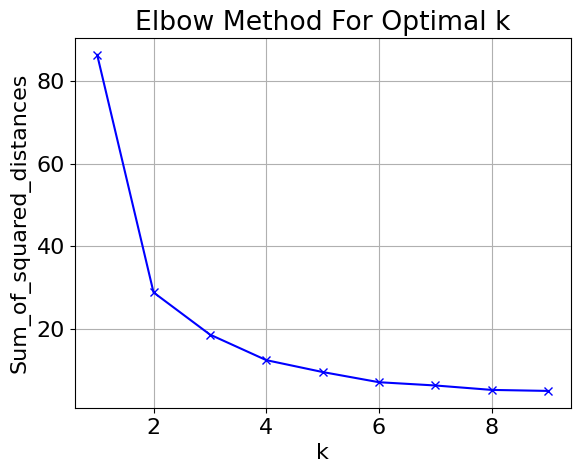

In [ ]:
# Calculate sum of squared distances for different k values
sum_of_squared_distances = []

# Range of k values to explore (1 to 0)
k_range = range(1, 10)
for k in k_range:
	# Create a KMeans model with k clusters and fixed random state
    kmeans = KMeans(n_clusters = k, max_iter=1000, random_state=0)
    # Fit the model to the data
    kmeans = kmeans.fit(data_umap)
    # Append the inertia (sum of squared distances) to the list
    sum_of_squared_distances.append(kmeans.inertia_)

# Elbow Method visualization
plt.plot(k_range, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)

plt.show()

# **Evaluating model**

In [ ]:
k_range = range(2,10) # Range of k values to explore (2 to 13)

# Initialize variables to track best k and score
best_n = -1
best_silhouette_score = -1

for k in k_range:
    # Create a KMeans model with the current k and fixed random state
    kmeans = KMeans(n_clusters = k, max_iter=1000, random_state=0)
    # Fit the model to the embedded data
    kmeans.fit(data_umap)
    # Predict cluster labels for the data
    clusters = kmeans.predict(data_umap)

    # Calculate silhouette score for the current k
    score = silhouette_score(data_umap, clusters)

    # Print results for each k
    print('k :',  k, 'score :', score)

    # Update best k and score if current score is better
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score

# Print results for the best k
print('best n :', best_n, 'best score :', best_silhouette_score )

k : 2 score : 0.5198164
k : 3 score : 0.40123457
k : 4 score : 0.4047293
k : 5 score : 0.39511415
k : 6 score : 0.4342735
k : 7 score : 0.38473302
k : 8 score : 0.35000598
k : 9 score : 0.28183317
best n : 2 best score : 0.5198164


<ipython-input-152-f80ebe600f5b>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)
<ipython-input-152-f80ebe600f5b>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)
<ipython-input-152-f80ebe600f5b>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(data_umap['UMAP1'][i], data_u

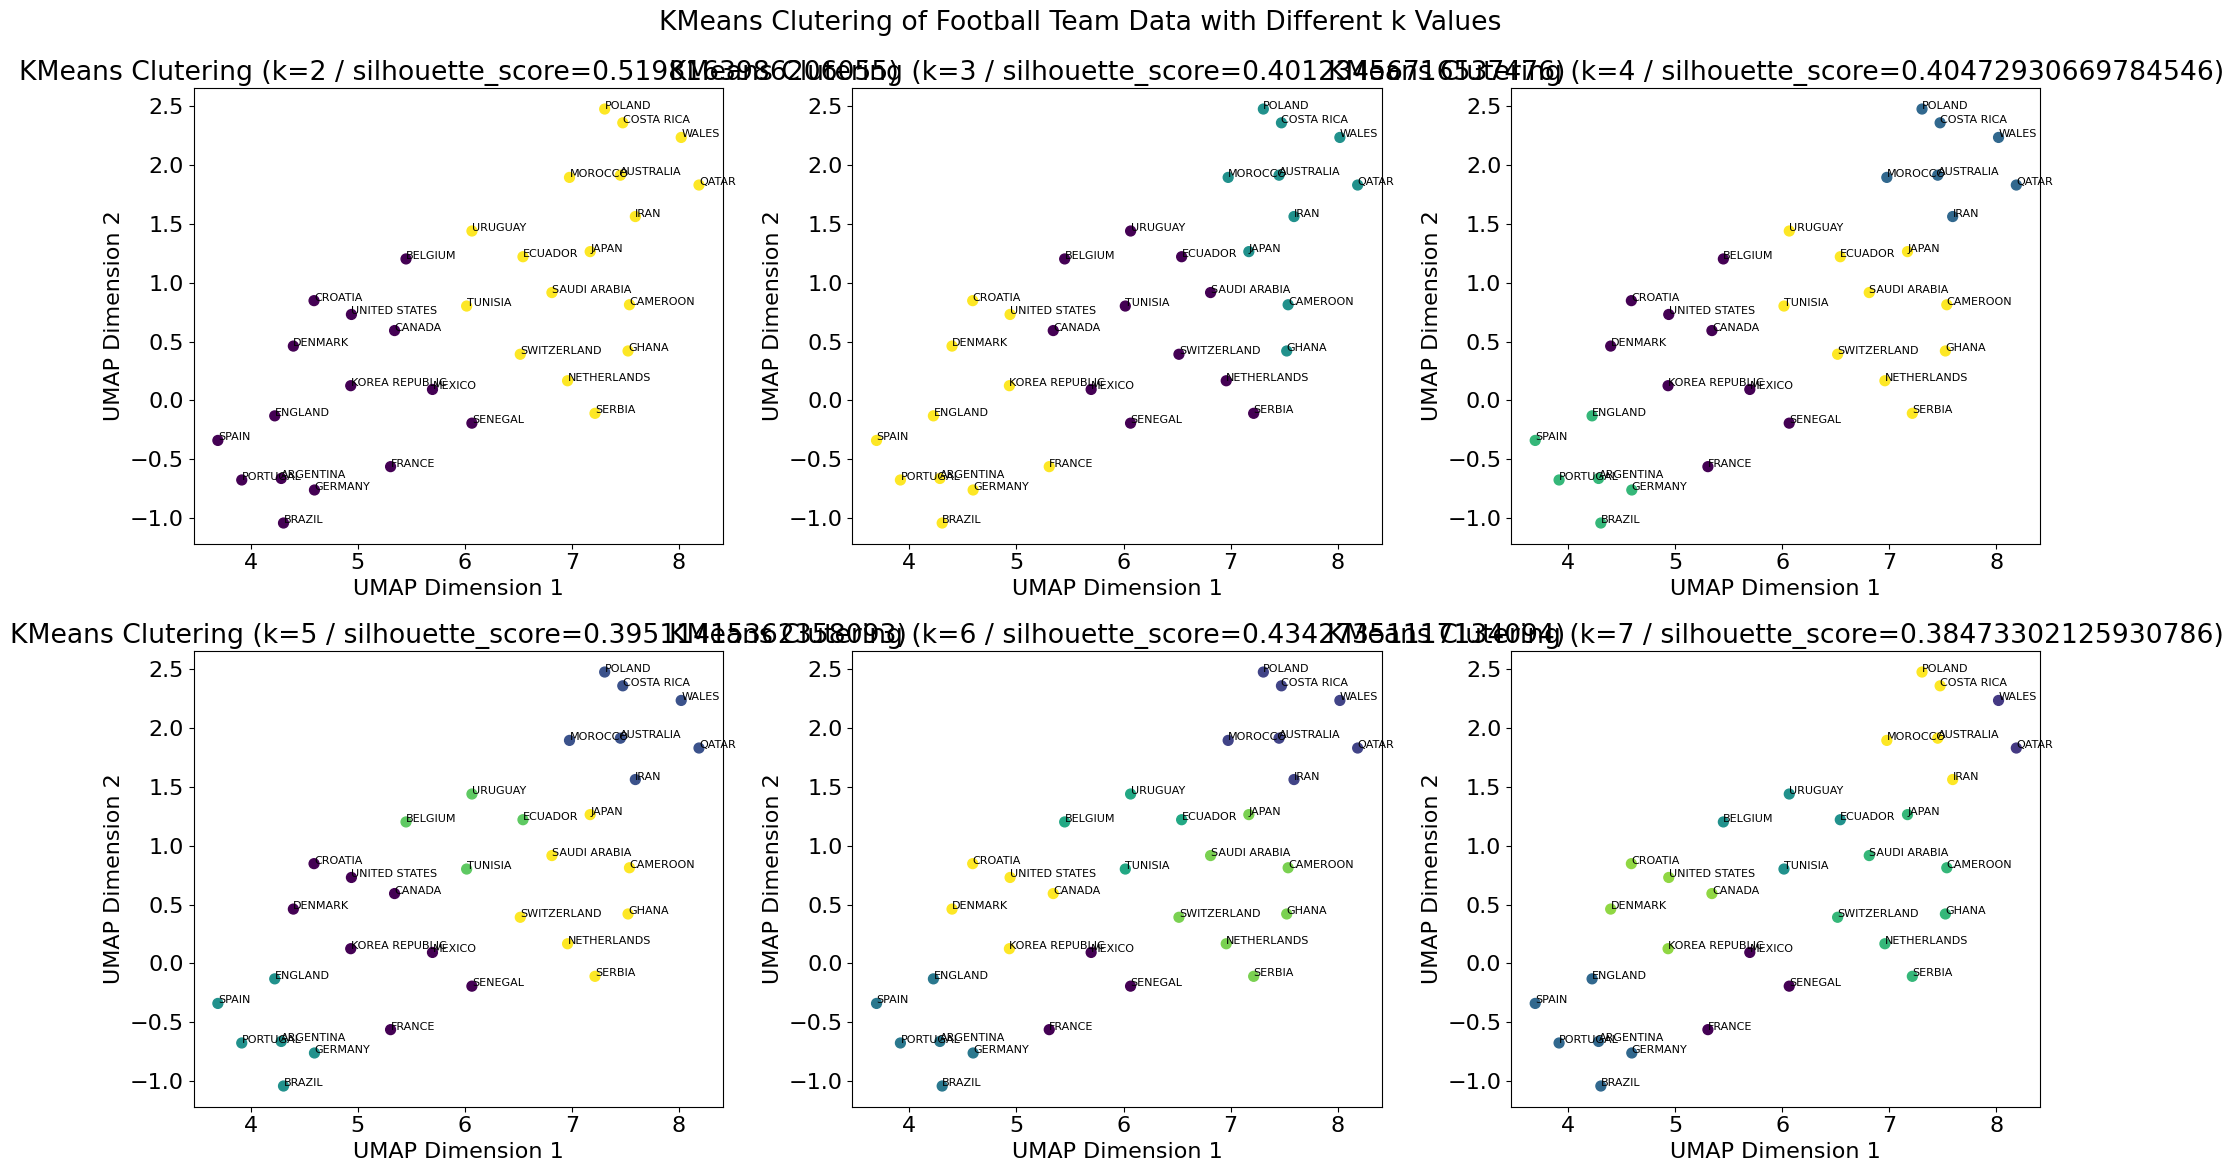

In [ ]:
# List of k values to visualize
k_values = [2, 3, 4, 5, 6, 7]

# Create a subplot grid to display multiple plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

for i, k in enumerate(k_values):
    # Create a KMeans model for the current k
    kmeans = KMeans(n_clusters = k, max_iter=1000, random_state=0)
    kmeans.fit(data_umap)
    clusters = kmeans.predict(data_umap)
    score = silhouette_score(data_umap, clusters)

    # Plot for the current k on the corresponding subplot
    ax = axes.flat[i]
    ax.scatter(data_umap['UMAP1'], data_umap['UMAP2'], c=clusters, s=50, cmap='viridis')


    # Add country labels to the plot
    for i, country in enumerate(data_umap.index):
        ax.text(data_umap['UMAP1'][i], data_umap['UMAP2'][i], country, fontsize=8)

    # Set labels and title for each subplot
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_title(f'KMeans Clutering (k={k} / silhouette_score={score})')

# Adjust layout and display the plots
fig.suptitle('KMeans Clutering of Football Team Data with Different k Values')
plt.tight_layout()
plt.show()

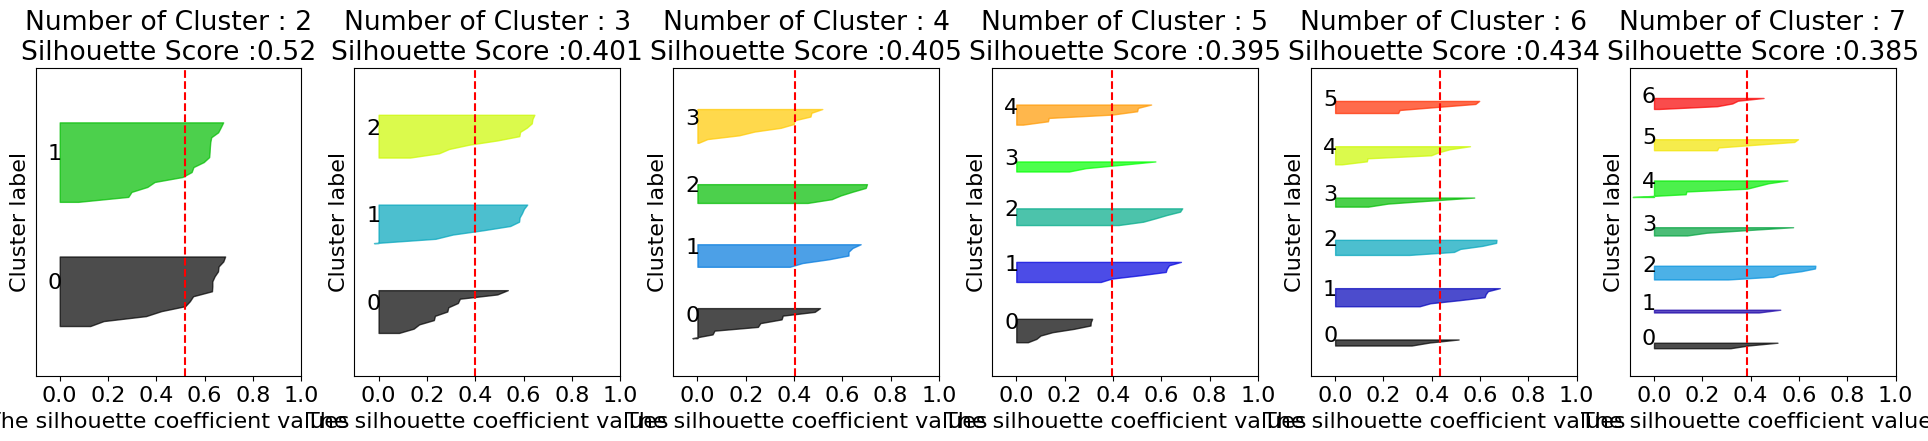

In [ ]:
# Visualizes silhouette coefficients for different numbers of clusters.
def visualize_silhouette(cluster_lists, X_features):
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # Get the number of cluster lists
    n_cols = len(cluster_lists)

    # Create subplots based on the number of cluster lists
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

     # Iterate through the cluster lists
    for ind, n_cluster in enumerate(cluster_lists):

        # Perform KMeans clustering and calculate silhouette score and values
        kmeans = KMeans(n_clusters = n_cluster, max_iter=1000, random_state=0)
        cluster_labels = kmeans.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the silhouette values for each cluster
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

#visualize silhouette scores for 2, 3, 4, and 5 clusters
visualize_silhouette([2, 3, 4, 5, 6, 7], data_umap)

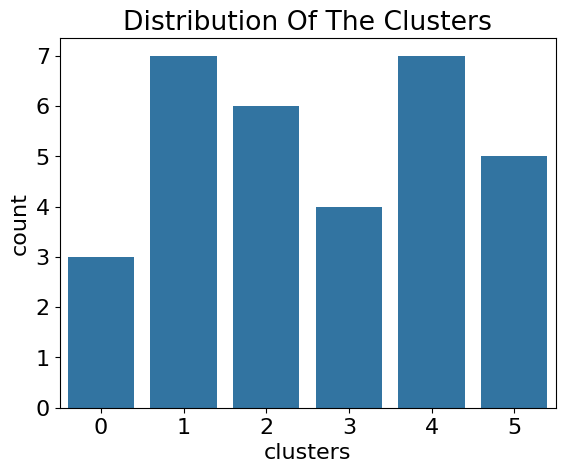

In [ ]:
# Initialize KMeans clustering with 6 clusters, maximum 1000 iterations, and a random state for reproducibility
kmeans = KMeans(n_clusters=6, max_iter=1000, random_state=0)

# Fit the KMeans model to the UMAP-reduced data
kmeans.fit(data_umap)

# Predict the cluster assignments for each data point
clusters = kmeans.predict(data_umap)

# Create a copy of the UMAP-reduced data
data_umap_copy = data_umap.copy()

# Add a new column 'clusters' to the copied DataFrame containing the cluster assignments
data_umap_copy['clusters'] = clusters

# Create a count plot (bar chart) visualizing the distribution of data points across the clusters
pl = sns.countplot(x=data_umap_copy["clusters"])

# Set the title of the plot
pl.set_title("Distribution Of The Clusters")

# Display the plot
plt.show()


In [ ]:
# Create a copy of the scaled data and add the cluster labels
data_standard_scaled_copy = data_standard_scaled.copy()
data_standard_scaled_copy['clusters'] = clusters
data_standard_scaled_copy = data_standard_scaled_copy.sort_values(by='clusters')

In [ ]:
# Final
final = ["ARGENTINA", "FRANCE"]

# Semi-final
semi_final = ["CROATIA", "MOROCCO"]

# Quarter-final
quarter_final = ["NETHERLANDS", "ENGLAND", "BRAZIL", "PORTUGAL"]

# Round of 16
round_of_16 = ["JAPAN", "SENEGAL", "AUSTRALIA", "SWITZERLAND", "SPAIN", "UNITED STATES", "POLAND", "KOREA REPUBLIC"]

# Group Stage
group_stage_eliminated = [
    "GERMANY", "ECUADOR", "CAMEROON", "URUGUAY", "TUNISIA", "MEXICO", "BELGIUM",
    "GHANA", "SAUDI ARABIA", "IRAN", "COSTA RICA", "DENMARK", "SERBIA", "WALES",
    "CANADA", "QATAR"
]

# Add Rank Score to data
def add_rank_score(df):
    df['Rank Score'] = 0
    df.loc[final, 'Rank Score'] = 4
    df.loc[semi_final, 'Rank Score'] = 3
    df.loc[quarter_final, 'Rank Score'] = 2
    df.loc[round_of_16, 'Rank Score'] = 1
    df.loc[group_stage_eliminated, 'Rank Score'] = 0

    return df

data_standard_scaled_copy = add_rank_score(data_standard_scaled_copy)

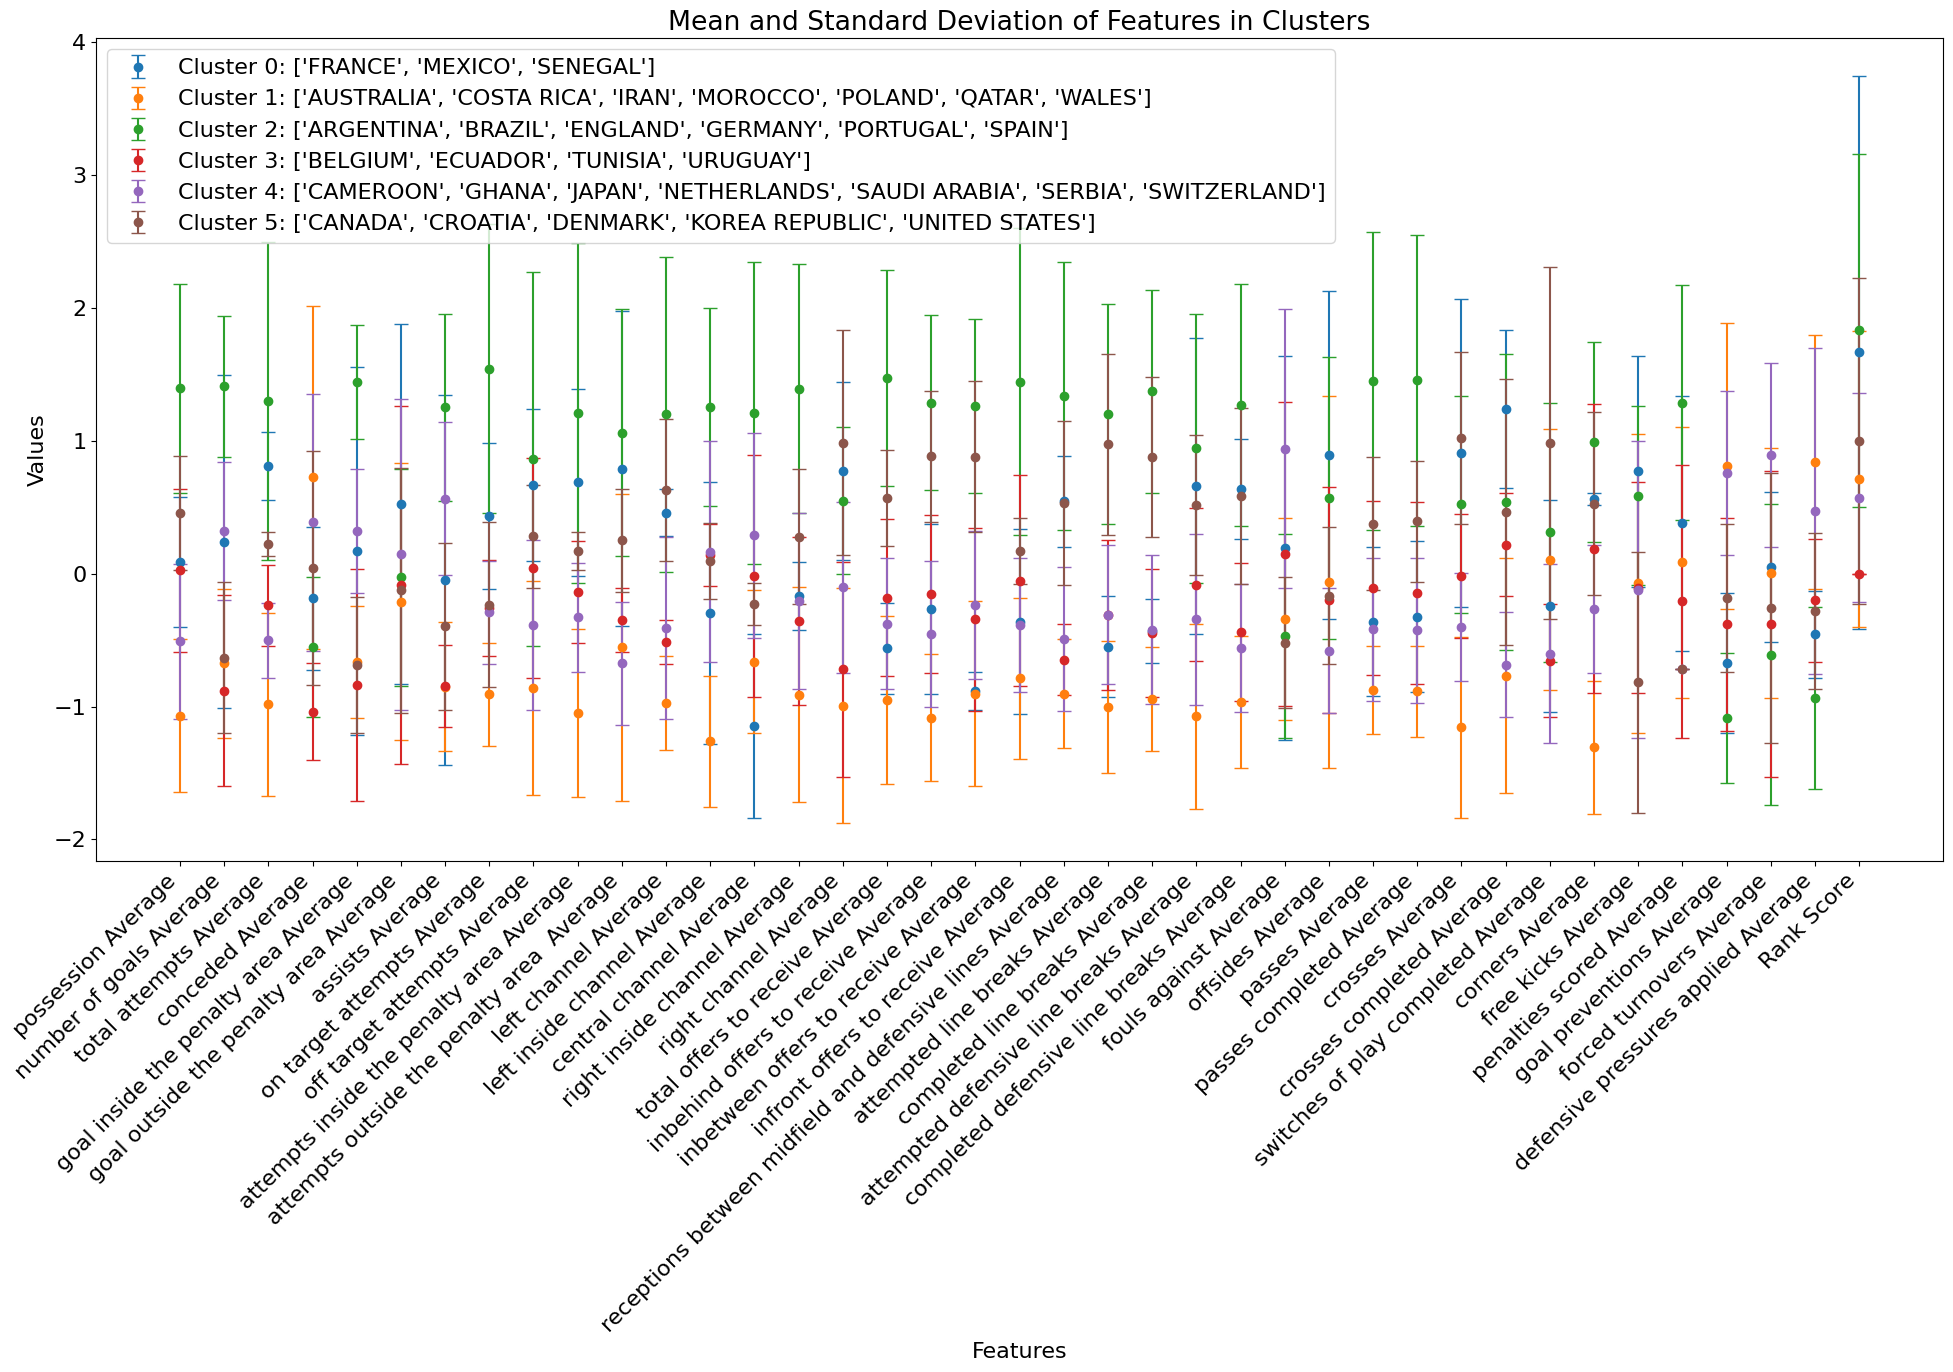

In [ ]:
# Plots the mean and standard deviation of features for specified clusters
def plot_cluster_mean_std(data, cluster_column='clusters', clusters_to_plot=None, figsize=(20, 14)):

    # Plot all unique clusters if no specific clusters are provided
    if clusters_to_plot is None:
        clusters_to_plot = data[cluster_column].unique()

    plt.figure(figsize=figsize)

    for cluster_num in clusters_to_plot:
        cluster_data = data[data[cluster_column] == cluster_num]
        cluster_mean_std = cluster_data.describe().drop(columns='clusters').loc[['mean', 'std']]
        country = sorted(data[data['clusters'] == cluster_num].index.tolist())

        plt.errorbar(
            x=cluster_mean_std.columns,
            y=cluster_mean_std.loc['mean'],
            yerr=cluster_mean_std.loc['std'],
            fmt='o',
            capsize=5,
            # Add label for each cluster, including country names
            label=f'Cluster {cluster_num}: {country}'
        )

    plt.title('Mean and Standard Deviation of Features in Clusters')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot all clusters
plot_cluster_mean_std(data_standard_scaled_copy)

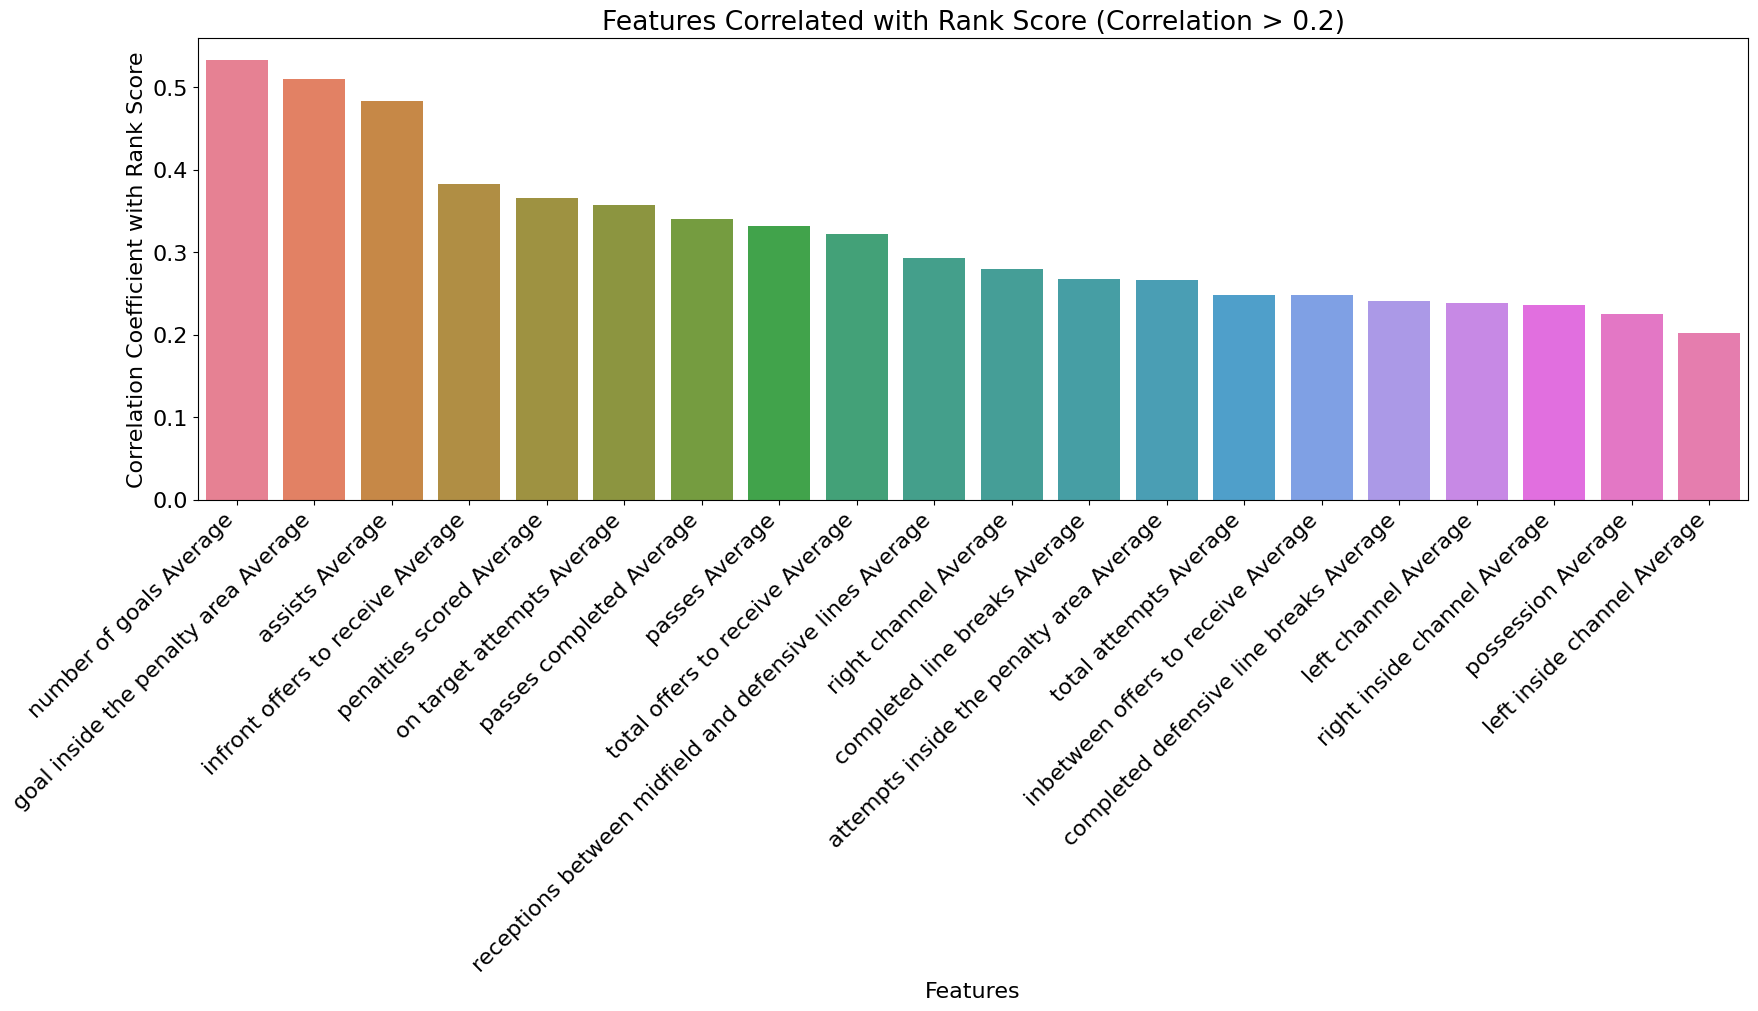

In [ ]:
# Calculate the correlation matrix for the standardized and scaled data
correlation_matrix = data_standard_scaled_copy.corr()

# Select features with a correlation coefficient greater than 0.2 with 'Rank Score'
rank_score_correlations = correlation_matrix[correlation_matrix['Rank Score'] > 0.2]

# Extract the 'Rank Score' column, sort in descending order, convert to DataFrame, and drop the 'Rank Score' row (making it suitable for barplot)
rank_score_correlations = rank_score_correlations['Rank Score'].sort_values(ascending=False).to_frame().drop(['Rank Score']).T

# Create a bar plot
plt.figure(figsize=(20, 6))
sns.barplot(data=rank_score_correlations)

# Add title and labels
plt.title('Features Correlated with Rank Score (Correlation > 0.2)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient with Rank Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

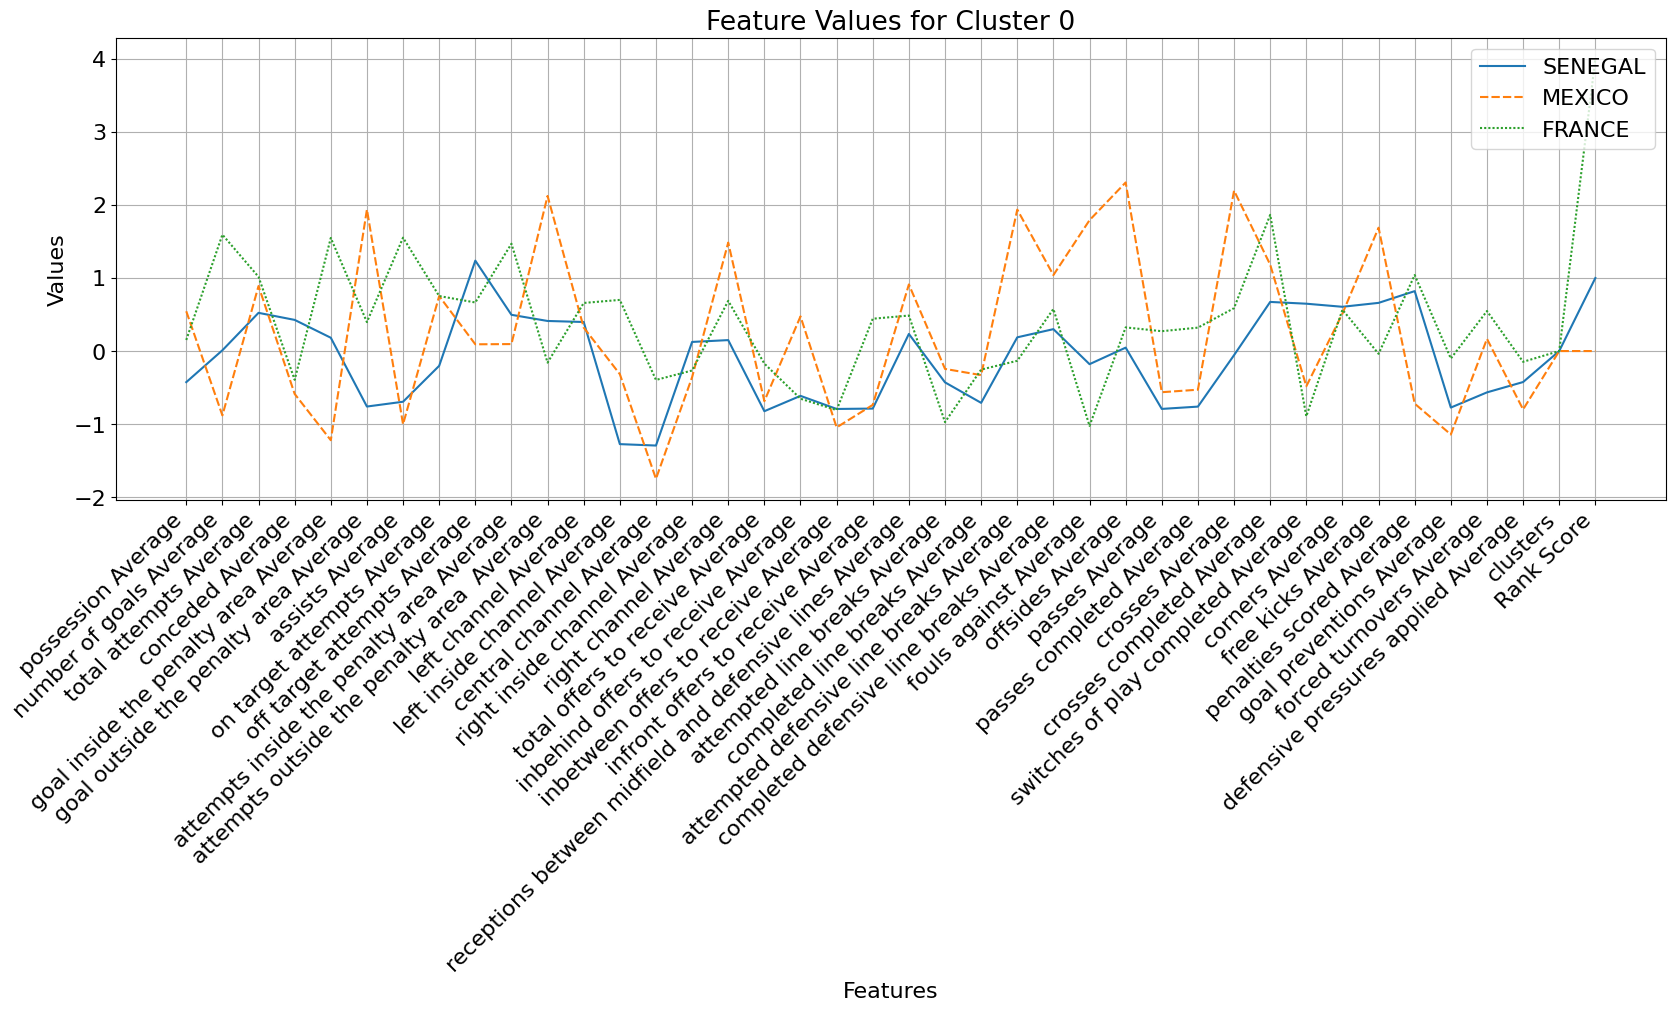

In [ ]:
data_cluster0 = data_standard_scaled_copy[data_standard_scaled_copy['clusters'] == 0]
data_cluster0.describe()

plt.figure(figsize=(20, 6))

sns.lineplot(data=data_cluster0.T)

plt.title('Feature Values for Cluster 0')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

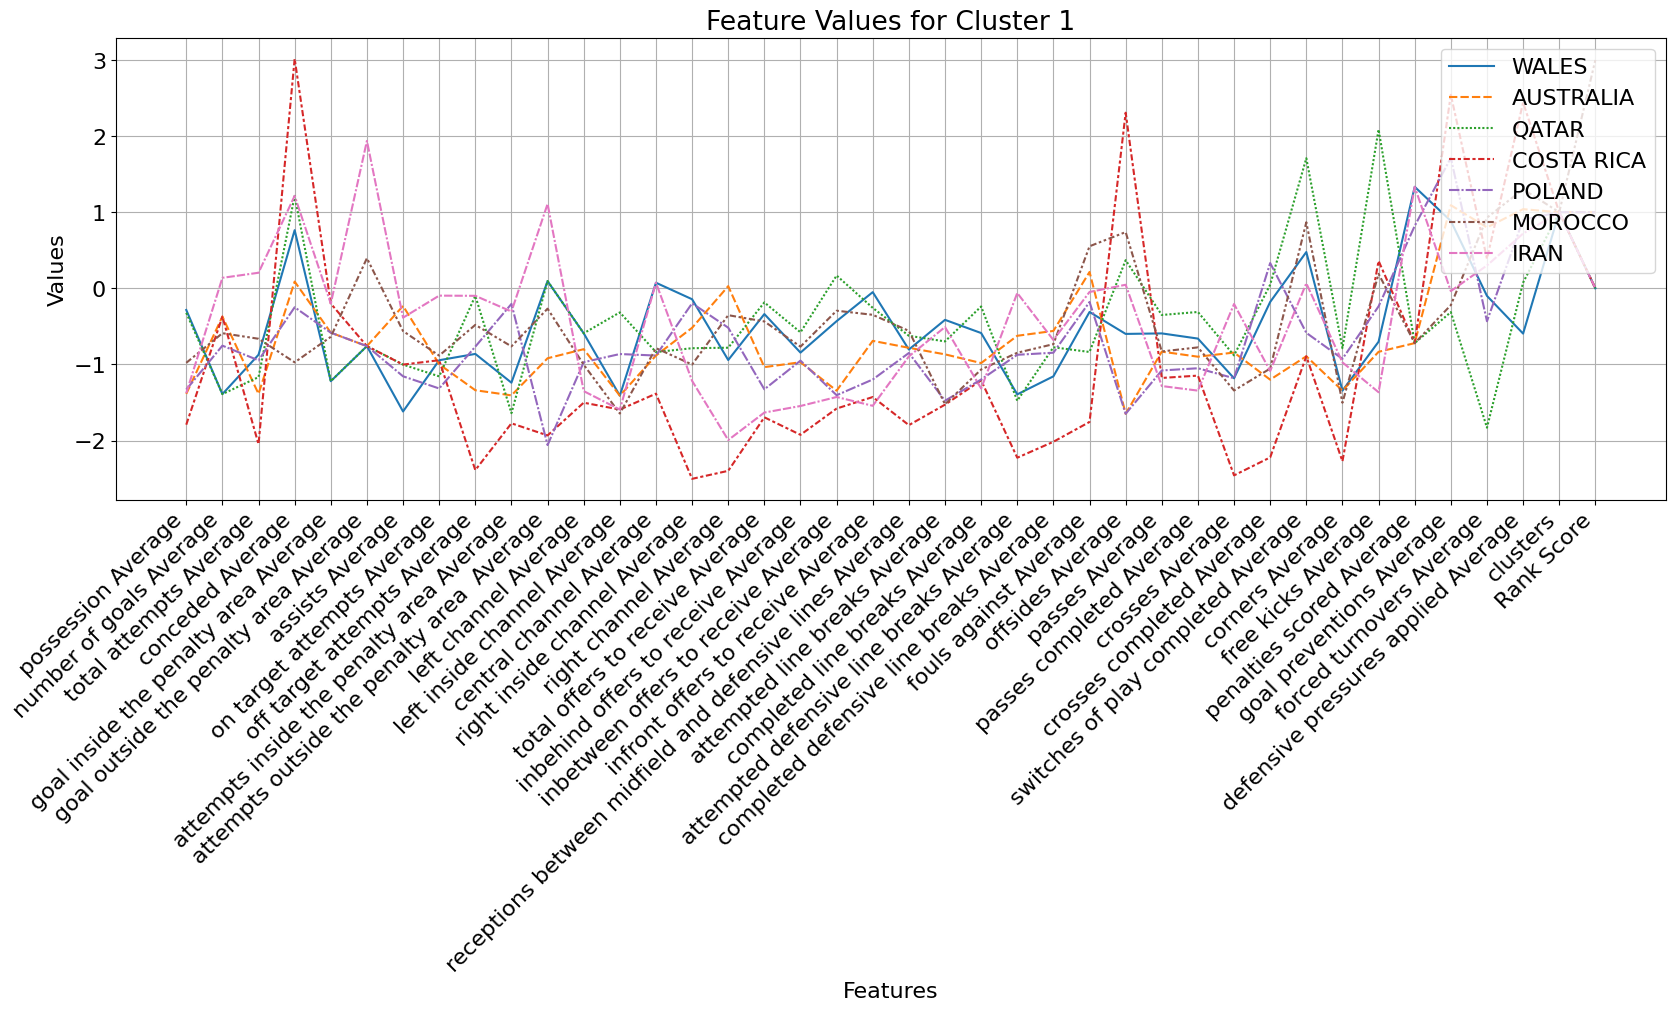

In [ ]:
data_cluster1 = data_standard_scaled_copy[data_standard_scaled_copy['clusters'] == 1]
data_cluster1.describe()

plt.figure(figsize=(20, 6))

sns.lineplot(data=data_cluster1.T)

plt.title('Feature Values for Cluster 1')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

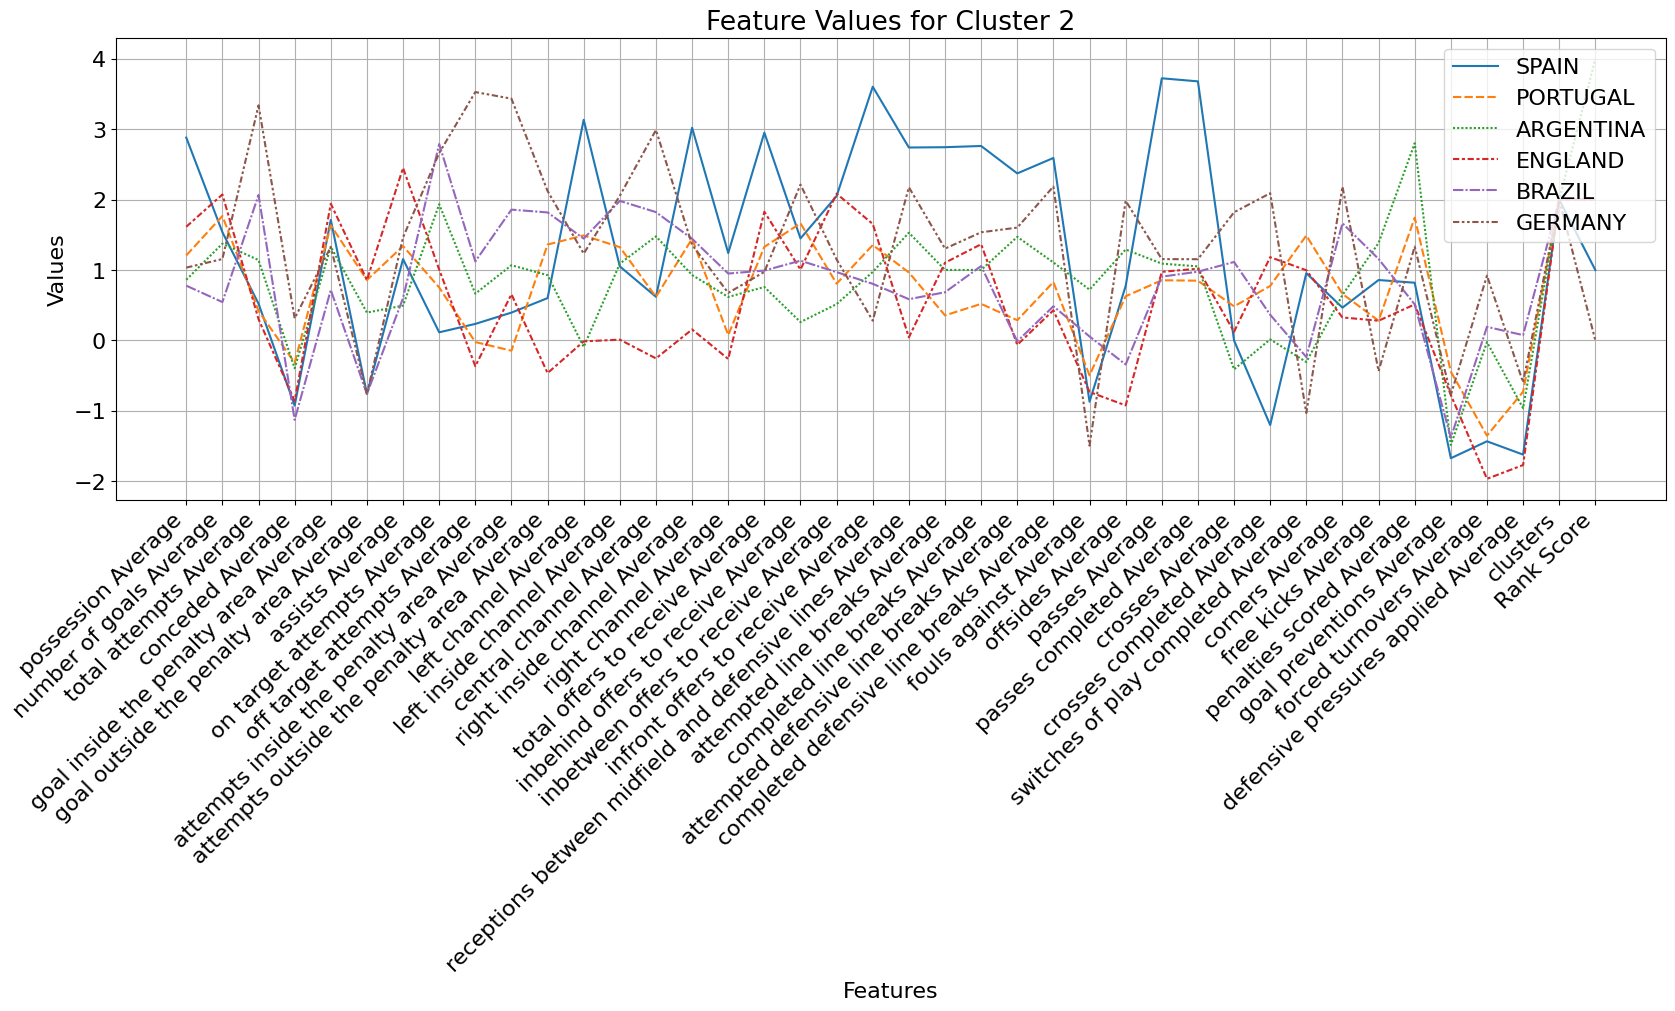

In [ ]:
data_cluster2 = data_standard_scaled_copy[data_standard_scaled_copy['clusters'] == 2]
data_cluster2.describe()

plt.figure(figsize=(20, 6))

sns.lineplot(data=data_cluster2.T)

plt.title('Feature Values for Cluster 2')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(loc='upper right')


plt.show()

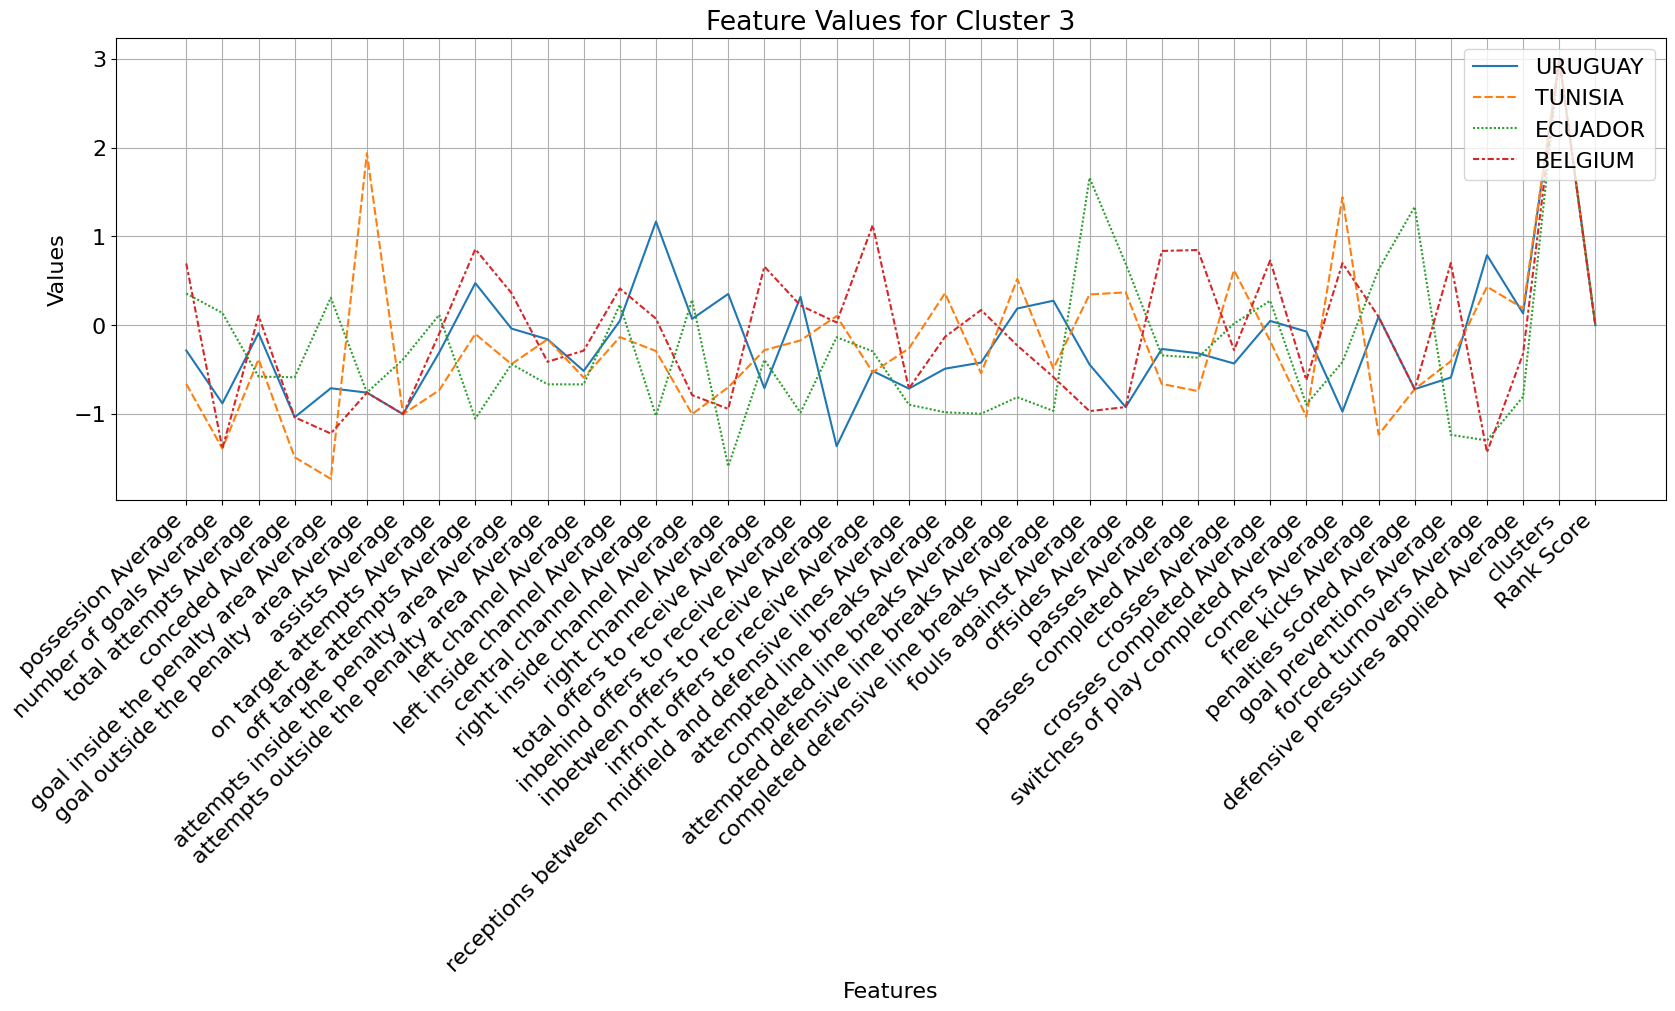

In [ ]:
data_cluster3 = data_standard_scaled_copy[data_standard_scaled_copy['clusters'] == 3]
data_cluster3.describe()

plt.figure(figsize=(20, 6))

sns.lineplot(data=data_cluster3.T)

plt.title('Feature Values for Cluster 3')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(loc='upper right')


plt.show()

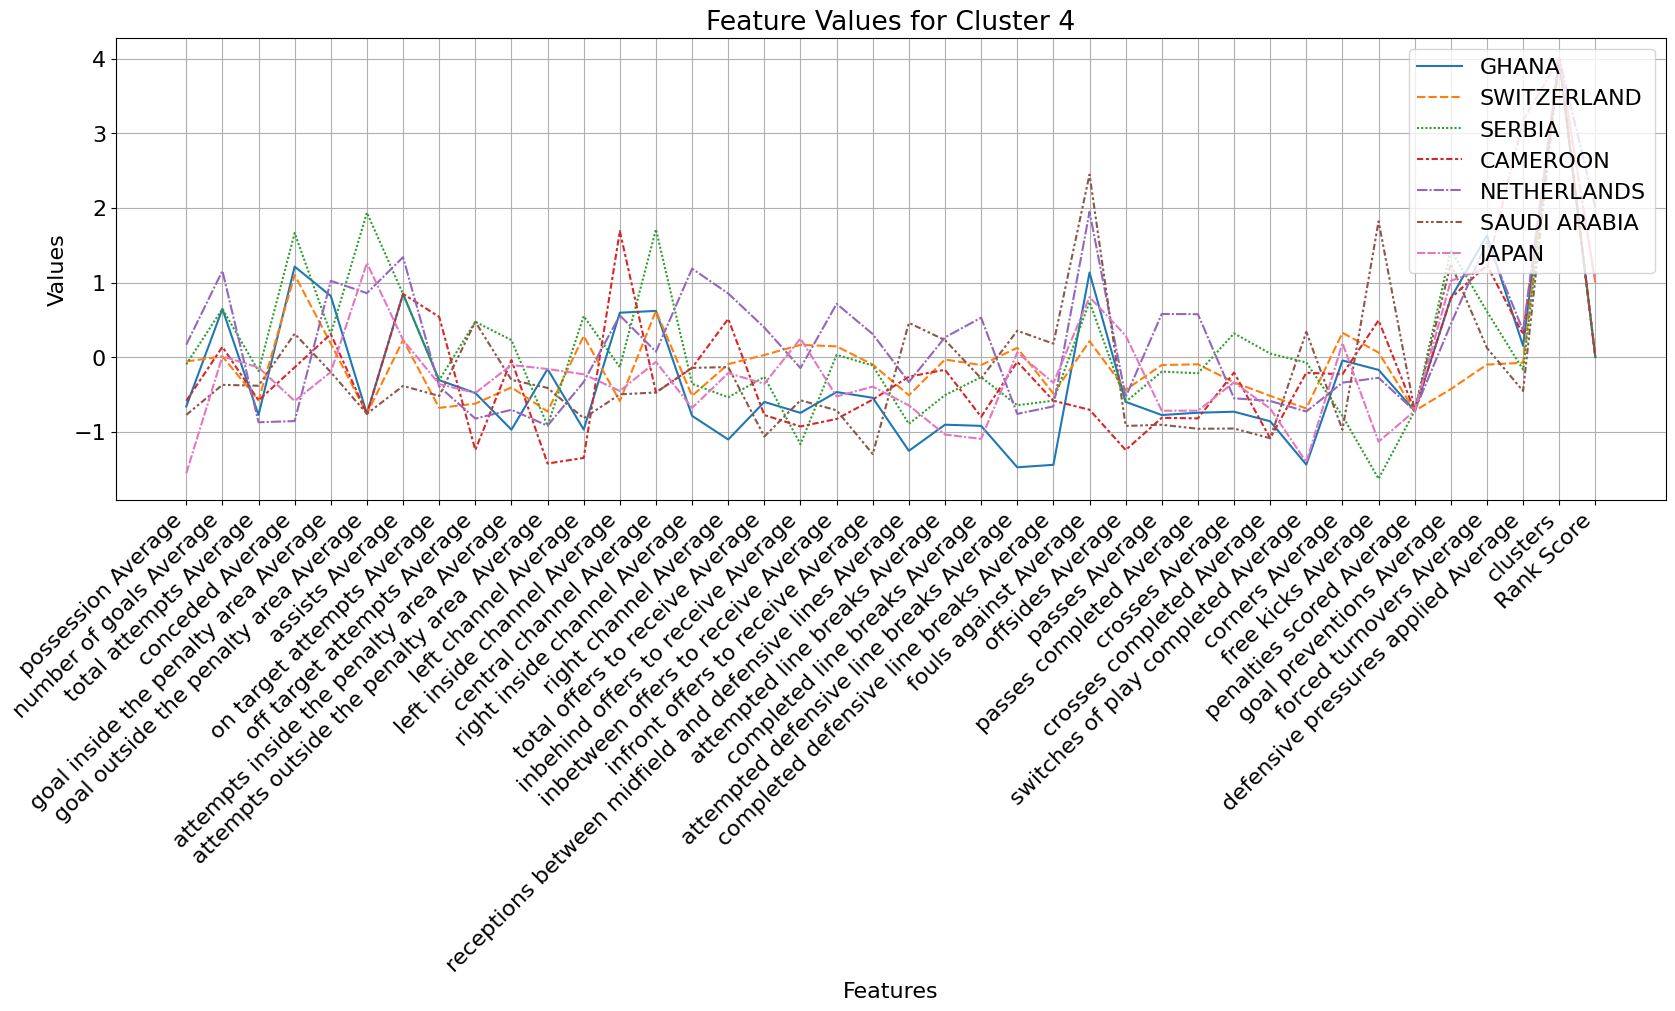

In [ ]:
data_cluster4 = data_standard_scaled_copy[data_standard_scaled_copy['clusters'] == 4]
data_cluster4.describe()

plt.figure(figsize=(20, 6))

sns.lineplot(data=data_cluster4.T)

plt.title('Feature Values for Cluster 4')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(loc='upper right')


plt.show()

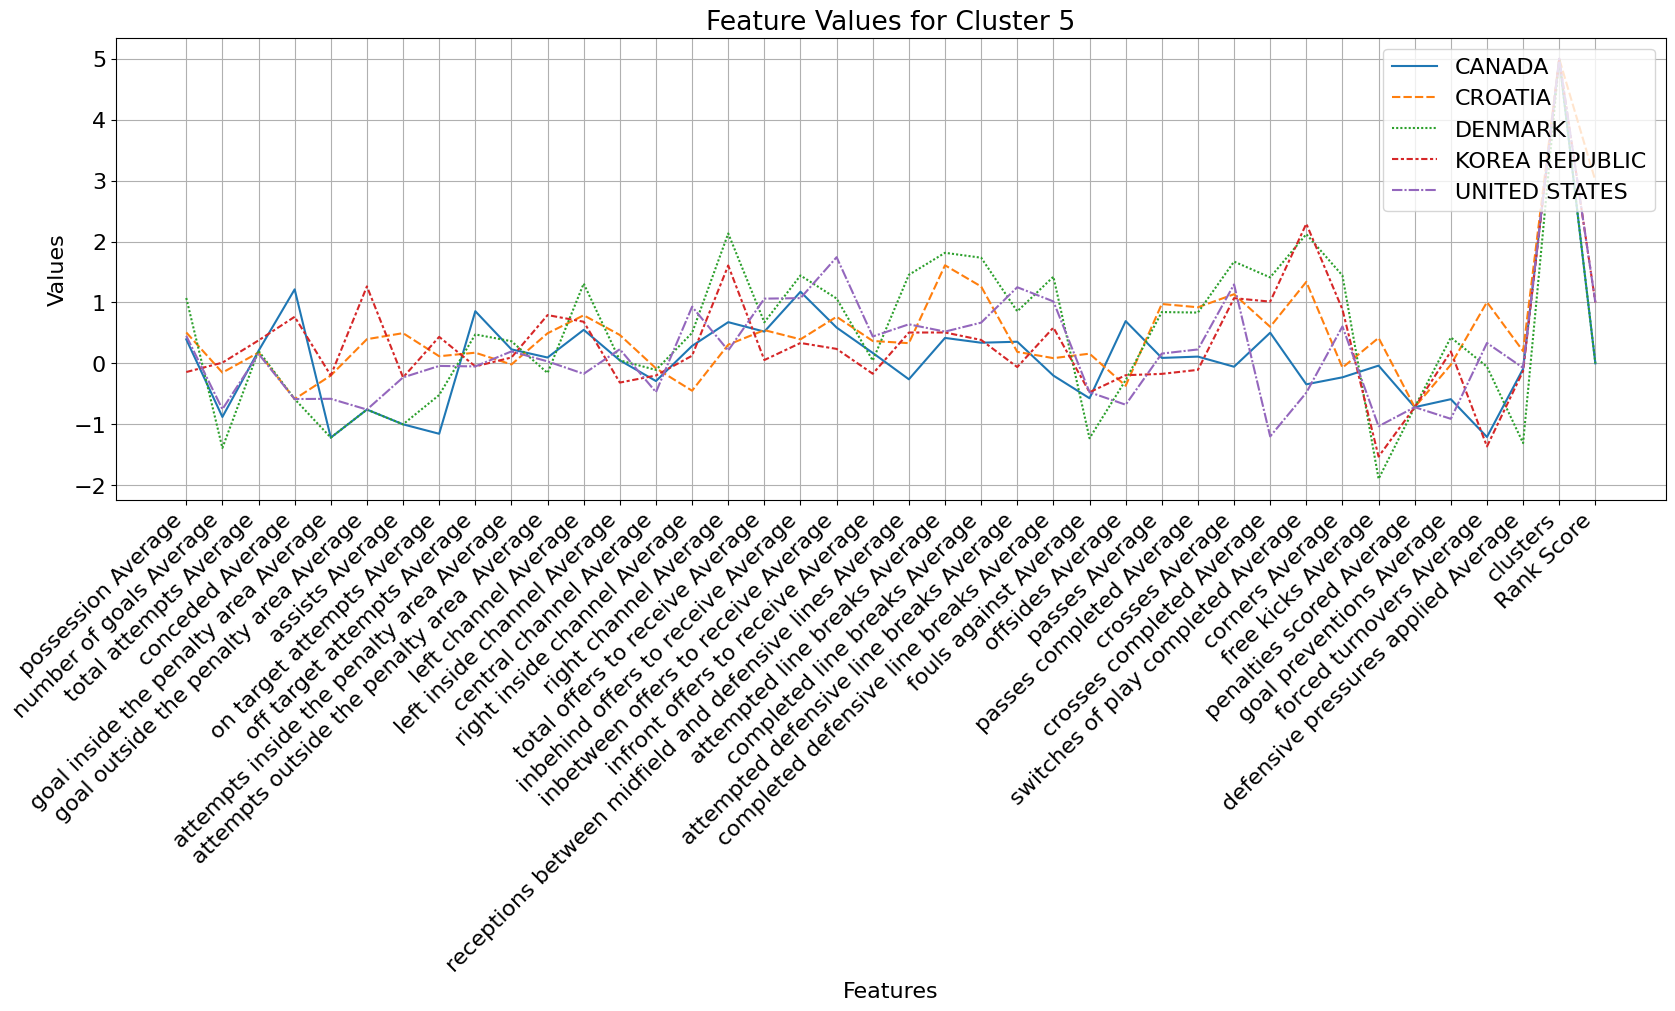

In [ ]:
data_cluster5 = data_standard_scaled_copy[data_standard_scaled_copy['clusters'] == 5]
data_cluster5.describe()

plt.figure(figsize=(20, 6))

sns.lineplot(data=data_cluster5.T)

plt.title('Feature Values for Cluster 5')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(loc='upper right')


plt.show()

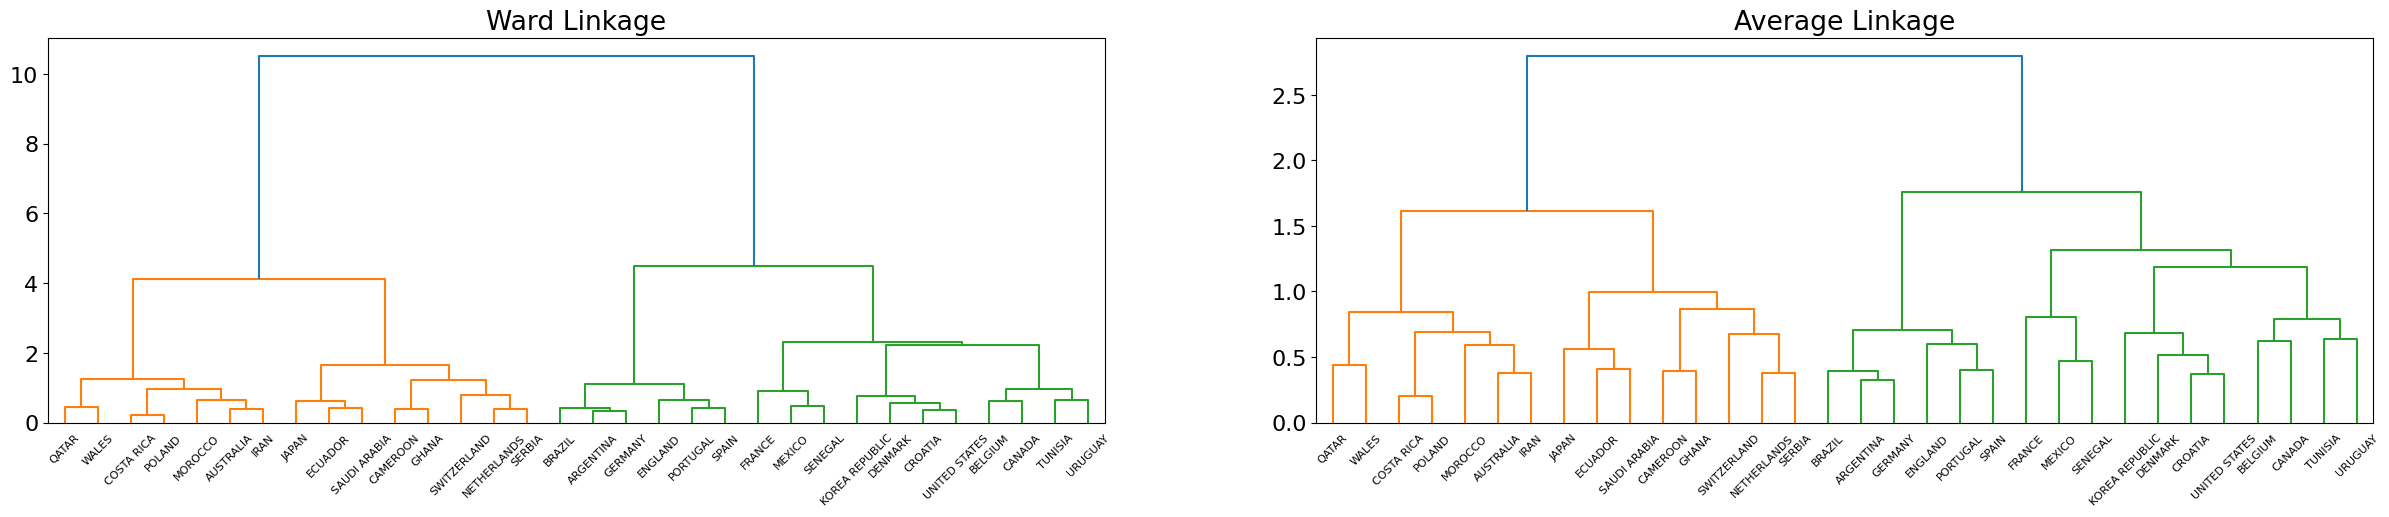

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


# Perform hierarchical clustering using Ward's method and average linkage method
linked_ward = linkage(data_umap, 'ward')
linked_average = linkage(data_umap, 'average')


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5))

# First dendrogram (Ward's method)
dendrogram(linked_ward, orientation='top', ax=ax1, labels=data_umap.index)
ax1.set_title('Ward Linkage')

# Second dendrogram (Average linkage)
dendrogram(linked_average, orientation='top', ax=ax2, labels=data_umap.index)
ax2.set_title('Average Linkage')

plt.show()